In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance, em_regularize_covariance, from_cov_to_precisions, cvxpy_ccp_iteration, KL_div
from experiments.utils.experiment_utils import *
from experiments.utils.factor_model import *

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Data

In [2]:
returns = 100*pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

# Risk-free rate
FF = pd.read_csv('../data/ff5.csv', index_col=0, parse_dates=True)
rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [4]:
cm_iewma_pairs = [(63, 125), (125, 250), (250, 500), (500, 1000)]

# CM-IEWMA
print("Computing IEWMAs")
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=250)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
print("Done computing IEWMAs")

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Computing IEWMAs
Done computing IEWMAs


In [4]:
covariance_no_reg = {result.time: result.covariance for result in results if result is not None}

NameError: name 'results' is not defined

In [3]:
def save_cov_to_csv(covs, name):
    """
    param covs: dictionary of time: covariance matrix
    name: name of the csv file

    Saves dataframe of upper triangular covariance matrices to csv file
    with indices being time stamps and columns being the upper triangular part
    """

    covs = {key: cov.values[np.triu_indices_from(cov.values, k=0)] for key, cov in covs.items()}
    covs = pd.DataFrame.from_dict(covs, orient='index')
    covs.index = pd.to_datetime(covs.index, format='%Y%m%d')
    covs.to_csv(f"results/{name}.csv")


def from_upper_triangular_to_full(cov):
    """
    param cov: upper triangular part of covariance matrix
    name: name of the csv file

    returns full covariance matrix
    """

    n = int(np.sqrt(2*len(cov)))
    
    # Reconstruct the full covariance matrix
    full_cov = np.zeros((n, n))
    rows, cols = np.triu_indices(n)
    full_cov[rows, cols] = cov
    full_cov[cols, rows] = cov

    return full_cov


def from_csv_to_cov(name, assets):
    """
    Reads csv file with upper triangular covariance matrices and, converts them
    to full covariance matrices and returns dictionary of time: covariance
    """
    covs = pd.read_csv(f"results/{name}.csv", index_col=0, parse_dates=True)
    covs = {key: pd.DataFrame(from_upper_triangular_to_full(cov), index=assets, columns=assets) for key, cov in covs.iterrows()}
    return covs 

In [4]:
covariance_no_reg = from_csv_to_cov("after_comb_covariance_no_reg", assets=returns.columns)

In [238]:
times = list(covariance_no_reg.keys())
time0 = times[-2000]

Sigma0 = {time0: covariance_no_reg[time0].iloc[:, :]}

r = 75
Sigmas_low_rank = dict(regularize_covariance(Sigma0, r=r, low_rank_format=True))
Thetas_low_rank = dict(from_cov_to_precisions(Sigmas_low_rank))

In [388]:
Sigma = Sigma0[time0].values
Gk = Thetas_low_rank[time0].G.values
solver = "CLARABEL"
E_cvx, G_cvx, obj_val_cvx = cvxpy_ccp_iteration(Sigma, Gk, solver)

Sigma_hat_cvx = np.linalg.inv(E_cvx-G_cvx@G_cvx.T)

In [239]:
G_init = Thetas_low_rank[time0].G
e_init = Thetas_low_rank[time0].e
Sigma_hat_init = np.linalg.inv(np.diag(e_init)-G_init@G_init.T)

In [240]:


rho = 100
max_iter = 100
eps_abs = 1e-6
eps_rel = 1e-6
alpha = 1.8
max_iter_ccp = 5


### XXX uncomment if history=True
temp = list(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha, max_iter_ccp=max_iter_ccp, history=True))[0]
time, lr, KL_ccp, history = temp
ccp_lr = {time: lr}
###

### XXX uncomment if history=False
# ccp_lr = dict(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho,
# max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha,
# max_iter_ccp=max_iter_ccp, history=False))
###

G_ccp = ccp_lr[time0].G
e_ccp = ccp_lr[time0].e

Sigma_hat_ccp = np.linalg.inv(np.diag(e_ccp.values)-G_ccp.values@G_ccp.values.T)

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


In [241]:
em_lr = {}

for time, (cov, KL_em) in em_regularize_covariance(Sigma0, Sigmas_low_rank, history=True):
    em_lr[time] = cov
Sigma_hat_em = em_lr[time0].F@em_lr[time0].F.T + np.diag(em_lr[time0].d.values)


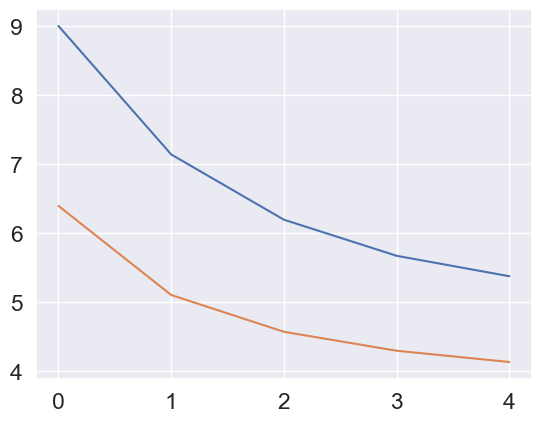

In [242]:
plt.plot(KL_ccp)
plt.plot(KL_em);

In [224]:
KL_div(Sigma_hat_init, Sigma0[time0])

19.226479364929617

In [225]:
KL_div(Sigma_hat_ccp, Sigma0[time0])

18.7853227642169

In [226]:
KL_div(Sigma_hat_em, Sigma0[time0])

18.767969955672413

In [195]:
KL_div(Sigma_hat_ccp, Sigma0[time0])

39.3401387374265

<Axes: >

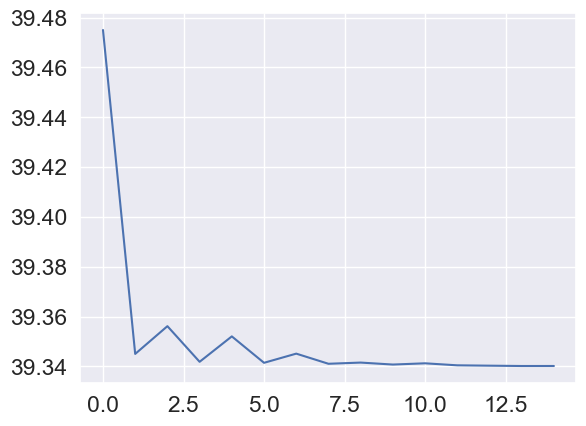

In [196]:
history.KL_divergence[:].plot()
# fix y axis
# plt.ylim([50,60])

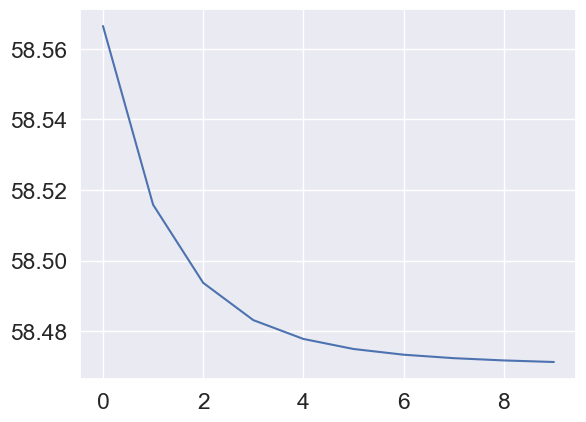

In [78]:
plt.plot(KL)

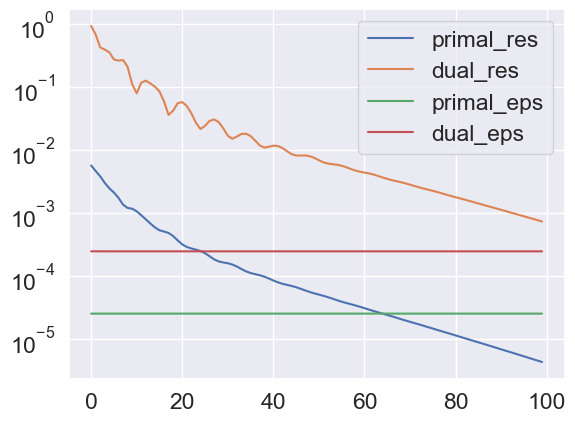

In [23]:
history.iloc[:,:4].plot()
# history.iloc[:,-1].plot()
plt.yscale("log")

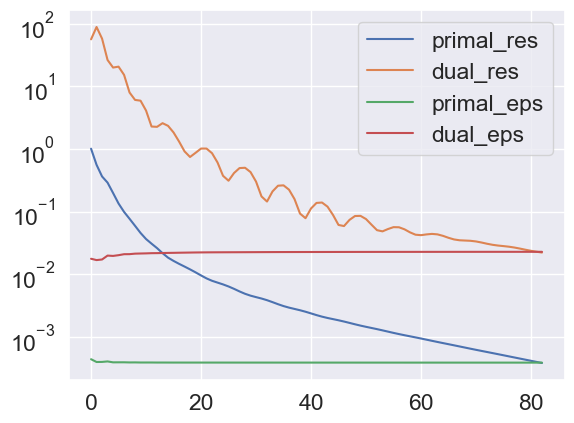

In [327]:
history.iloc[:,:4].plot()
# history.iloc[:,-1].plot()
plt.yscale("log")

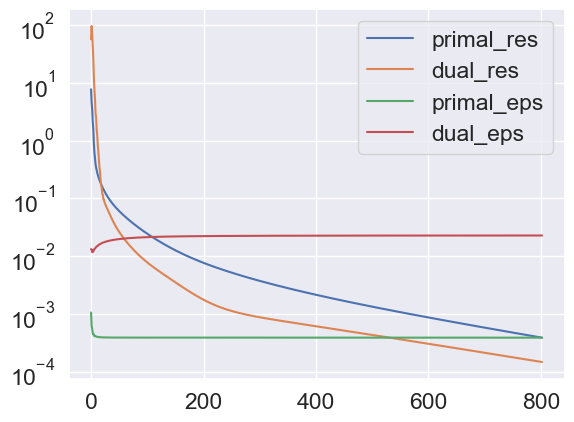

In [311]:
history.iloc[:,:4].plot()
# history.iloc[:,-1].plot()
plt.yscale("log")

<Axes: >

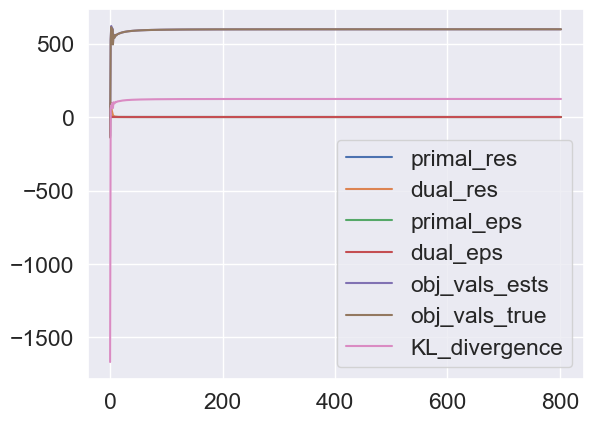

In [309]:
history.plot()

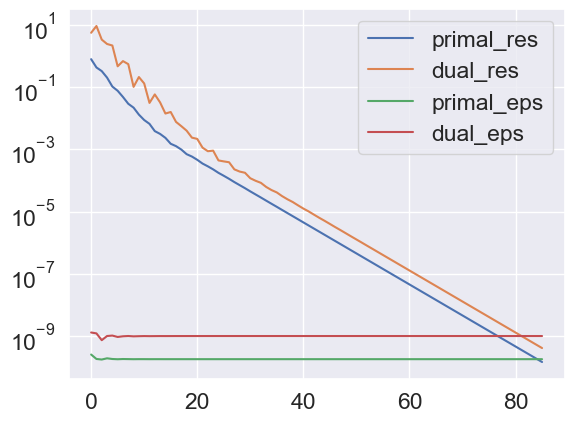

In [293]:
history.iloc[:,:4].plot()
# history.iloc[:,-1].plot()
plt.yscale("log")

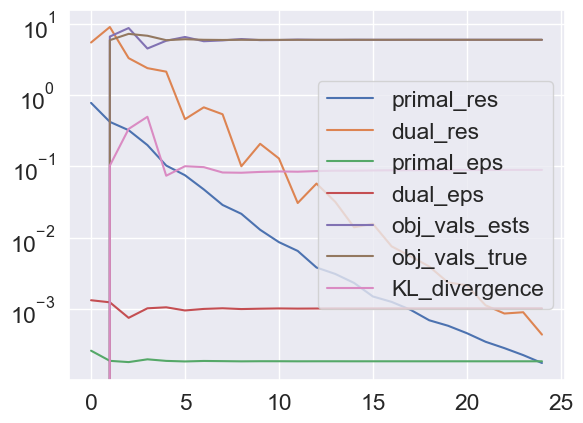

In [285]:
history.plot()
plt.yscale("log");

In [249]:
np.linalg.eigvals(Sigma_hat_ccp)

array([56.7153691 , 11.51837621,  3.41122262,  6.18108596,  6.48423102])

In [250]:
np.linalg.eigvals(Sigma_hat_cvx)


array([47.2824023 , 11.52900914,  3.40168087,  6.12235573,  6.40780378])

In [294]:
print("KL cvx: ", KL_div(Sigma_hat_cvx, Sigma))
print("KL ccp: ", KL_div(Sigma_hat_ccp, Sigma))

print("KL divergence between cvxpy and ccp: ", KL_div(Sigma_hat_cvx, Sigma_hat_ccp))

KL cvx:  0.08944608350118077
KL ccp:  0.08939697003657265
KL divergence between cvxpy and ccp:  6.502639493533025e-08


In [254]:
G_ccp

,0,1
8048,-0.147807,-0.053868
20792,-0.145843,0.116365
10486,-0.220057,-0.036914
21880,-0.132671,0.545417
2367,-0.220315,-0.086652


In [255]:
G_cvx

array([[-0.14477207, -0.05348862],
       [-0.14531766,  0.11697474],
       [-0.21928728, -0.03620924],
       [-0.13254227,  0.54511224],
       [-0.21970026, -0.08745468]])

In [6]:
ll2_test = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=2)


In [344]:
times = list(covariance_no_reg.keys())

t0 = times[:100]
Sigma0 = {t: covariance_no_reg[t] for t in t0}
Sigmas_low_rank = dict(regularize_covariance(Sigma0, r=100, low_rank_format=True))
Thetas_low_rank = dict(from_cov_to_precisions(Sigmas_low_rank))

In [345]:
F2, e2 = Sigmas_low_rank[t0[0]]

In [353]:
(e2-e).abs().max()

1.3500311979441904e-13

In [354]:
Sigma_temp = F@F.T + np.diag(e.values)
Sigma_temp2 = F2@F2.T + np.diag(e2.values)

In [357]:
(Sigma_temp- Sigma_temp2).abs().max().max()

1.5631940186722204e-13

In [79]:
F, e = Sigmas_low_rank[t0[0]]

NameError: name 't0' is not defined

In [335]:
eigvals, eigvecs = np.linalg.eigh(Sigma0[t0[0]].values)

In [80]:
em_lr = {}

for time, (cov, KL) in em_regularize_covariance(Sigma0, Sigmas_low_rank, history=True):
    em_lr[time] = cov
Sigma_hat_em = em_lr[time0].F@em_lr[time0].F.T + np.diag(em_lr[time0].d.values)


In [93]:
Sigma_hat_em

,8048,20792,10486,21880,2367,20678,20990,20483,8045,21645,...,21326,20048,2093,20906,20064,912,1467,31668,5057,21308
8048,4.094818,2.184934,1.769562,0.996956,2.282454,1.710189,1.481636,2.356109,1.743515,1.343512,...,1.523778,2.162088,2.312336,1.018741,2.305740,2.115827,2.282952,1.098546,2.508367,2.485209
20792,2.184934,4.604433,1.795527,0.811483,2.524353,2.033947,1.504500,2.887814,1.803259,1.324902,...,1.199992,2.458321,2.889132,0.703033,2.866761,2.214743,2.313382,1.132638,3.147714,2.850797
10486,1.769562,1.795527,2.833365,0.829369,1.880135,1.404755,1.224226,1.932921,1.439690,1.111199,...,1.268760,1.779109,1.895472,0.851021,1.890460,1.746384,1.886461,0.907212,2.055781,2.044292
21880,0.996956,0.811483,0.829369,2.118372,0.944062,0.621416,0.693745,0.804453,0.796559,0.652799,...,0.922934,0.853814,0.756354,0.676890,0.762719,0.950726,1.071838,0.504033,0.812242,0.966288
2367,2.282454,2.524353,1.880135,0.944062,5.349151,1.988980,1.574864,2.789512,1.872126,1.405401,...,1.419732,2.449454,2.769330,0.892054,2.753296,2.287107,2.423838,1.177536,3.011962,2.829961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,2.115827,2.214743,1.746384,0.950726,2.287107,1.737300,1.462416,2.407661,1.726341,1.319561,...,1.446437,2.177618,2.372043,0.950583,2.362934,4.053678,2.252541,1.087136,2.575399,2.507217
1467,2.282952,2.313382,1.886461,1.071838,2.423838,1.809700,1.579464,2.489342,1.857154,1.433994,...,1.640047,2.292992,2.440615,1.100949,2.434290,2.252541,4.021351,1.170306,2.646906,2.634545
31668,1.098546,1.132638,0.907212,0.504033,1.177536,0.887344,0.759639,1.225517,0.895068,0.687430,...,0.768953,1.117813,1.204694,0.510581,1.200757,1.087136,1.170306,2.524409,1.307307,1.285756
5057,2.508367,3.147714,2.055781,0.812242,3.011962,2.503185,1.723227,3.596727,2.084585,1.494560,...,1.171772,2.969123,3.624945,0.611827,3.590174,2.575399,2.646906,1.307307,5.684434,3.456222


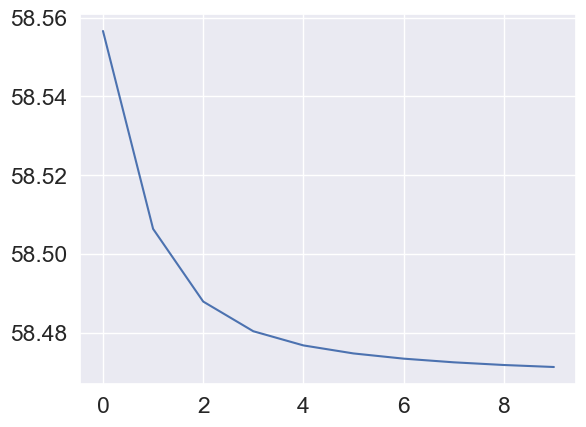

In [81]:
plt.plot(KL)

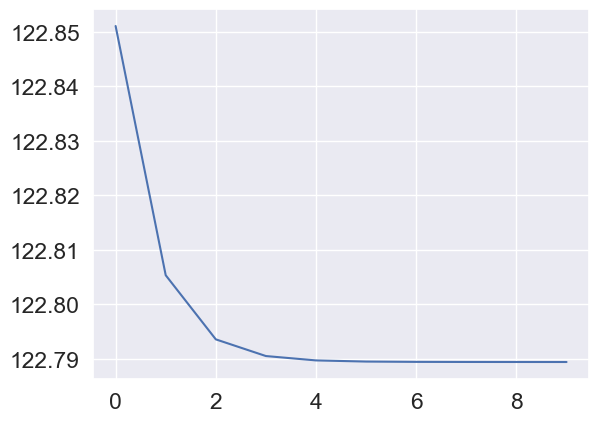

In [61]:
plt.plot(KL)

In [58]:
Sigma_hat_em = em_lr[time0].F @ em_lr[time0].F.T + np.diag(em_lr[time0].d)

In [59]:
KL_div(Sigma_hat_em, Sigma0[time0])

122.78940936031299

In [162]:
Sigma_hat_init

(5787, 238)

In [161]:
2 * 10 * 6 / 10

12.0

In [383]:
rho = 100
max_iter = 10
eps_abs = 1e-1
eps_rel = 1e-1
alpha = 1.8
max_iter_ccp = 1

In [384]:
start = time.time()
ccp_lr = dict(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha, max_iter_ccp=max_iter_ccp))
end = time.time()
(end - start) / len(Sigma0)

0.34590764045715333

In [385]:
(end - start) / len(Sigma0)

0.34590764045715333

In [363]:
(end - start) / len(Sigma0)

0.0441437292098999

In [82]:
start = time.time()
em_lr = dict(em_regularize_covariance(Sigma0, Sigmas_low_rank))
end = time.time()
(end-start) / len(Sigma0)

TypeError: unsupported operand type(s) for -: 'datetime.time' and 'datetime.time'

In [191]:
(end-start) / 100

0.03656162977218628

In [198]:
# create

I = eye(10)
U = np.random.normal(size=(10,10))

In [201]:
type(I + U)

numpy.matrix

In [196]:
I

<10x10 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements (1 diagonals) in DIAgonal format>

In [70]:
def ccp_profile():
    return dict(ccp_regularize_covariance(Sigma0, Thetas_low_rank, rho=rho, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha, max_iter_ccp=max_iter_ccp))

In [193]:
cProfile.run('ccp_profile()', sort='cumtime')

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:25<00:00,  3.97it/s]

         2225955 function calls (2223155 primitive calls) in 25.221 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   25.221   25.221 {built-in method builtins.exec}
        1    0.000    0.000   25.221   25.221 <string>:1(<module>)
        1    0.000    0.000   25.220   25.220 3629274568.py:1(ccp_profile)
      101    0.002    0.000   25.220    0.250 regularization.py:183(ccp_regularize_covariance)
      100    0.001    0.000   25.112    0.251 regularization.py:228(CCP)
      500    0.004    0.000   25.111    0.050 regularization.py:286(update)
      500    0.017    0.000   25.106    0.050 regularization.py:294(_ADMM_ccp_iteration)
      500    0.787    0.002   20.994    0.042 regularization.py:455(update_X)
      500   15.884    0.032   15.892    0.032 linalg.py:1348(eigh)
    13000    0.071    0.000    4.635    0.000 _compressed.py:27(__init__)
6500/4500    0.591    0.000    3.814    0.001 _

In [194]:
20 / 25

0.8

In [166]:
cProfile.run('ccp_profile()', sort='cumtime')

 23%|██▎       | 23/100 [00:12<00:40,  1.88it/s]


         1696668 function calls (1696020 primitive calls) in 12.213 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   12.213   12.213 {built-in method builtins.exec}
        1    0.000    0.000   12.213   12.213 <string>:1(<module>)
        1    0.000    0.000   12.213   12.213 3629274568.py:1(ccp_profile)
       24    0.001    0.000   12.213    0.509 regularization.py:183(ccp_regularize_covariance)
       24    0.000    0.000   12.148    0.506 regularization.py:228(CCP)
      116    0.001    0.000   12.147    0.105 regularization.py:286(update)
      116    0.005    0.000   12.146    0.105 regularization.py:294(_ADMM_ccp_iteration)
      116    1.835    0.016   11.258    0.097 regularization.py:455(update_X)
      116    0.011    0.000    8.347    0.072 arpack.py:1360(eigsh)
    24656    3.038    0.000    5.840    0.000 arpack.py:535(iterate)
    24540    0.037    0.000    2.802    0.000 _inte

KeyboardInterrupt: 

# Experiments

In [25]:
rho = 1e-3
max_iter = 10
eps_abs = 1e-6
eps_rel = 1e-4
alpha = 1.8
max_iter_ccp = 10
rank = 75


ll2_ccp = ccp_low_rank_log_likelihood(returns, covariance_no_reg, rank=rank, rho=rho, max_iter=max_iter, eps_abs=eps_abs, eps_rel=eps_rel, alpha=alpha, max_iter_ccp=max_iter_ccp)

  0%|          | 8/5466 [02:20<26:41:23, 17.60s/it]


KeyboardInterrupt: 

In [14]:
ll2 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=2)
ll2.to_csv("results/after_comb_ll2_em.csv")
ll5 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=5)
ll5.to_csv("results/after_comb_ll5_em.csv")
ll10 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=10)
ll10.to_csv("results/after_comb_ll10_em.csv")
ll20 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=20)
ll20.to_csv("results/after_comb_ll20_em.csv")
ll35 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=35)
ll35.to_csv("results/after_comb_ll35_em.csv")
ll50 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=50)
ll50.to_csv("results/after_comb_ll50_em.csv")
ll60 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=60)
ll60.to_csv("results/after_comb_ll60_em.csv")
ll75 = em_low_rank_log_likelihood(returns, covariance_no_reg, rank=75)
ll75.to_csv("results/after_comb_ll75_em.csv")

100%|██████████| 5466/5466 [02:36<00:00, 34.98it/s]


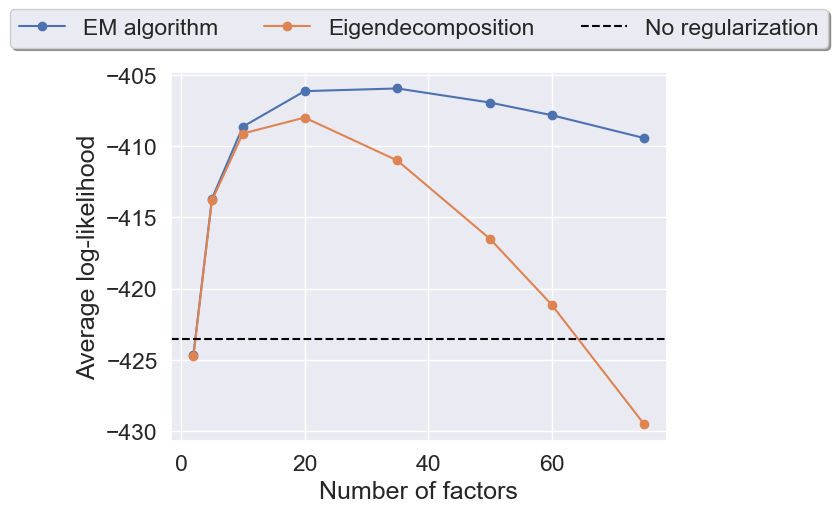

In [15]:
ll2_em = pd.read_csv("results/after_comb_ll2_em.csv",index_col=0).squeeze()
ll5_em = pd.read_csv("results/after_comb_ll5_em.csv",index_col=0).squeeze()
ll10_em = pd.read_csv("results/after_comb_ll10_em.csv",index_col=0).squeeze()
ll20_em = pd.read_csv("results/after_comb_ll20_em.csv",index_col=0).squeeze()
ll35_em = pd.read_csv("results/after_comb_ll35_em.csv",index_col=0).squeeze()
ll50_em = pd.read_csv("results/after_comb_ll50_em.csv",index_col=0).squeeze()
ll60_em = pd.read_csv("results/after_comb_ll60_em.csv",index_col=0).squeeze()
ll75_em = pd.read_csv("results/after_comb_ll75_em.csv",index_col=0).squeeze()

ll2_eig = pd.read_csv("results/after_comb_ll_r=2.csv",index_col=0).squeeze()
ll5_eig = pd.read_csv("results/after_comb_ll_r=5.csv",index_col=0).squeeze()
ll10_eig = pd.read_csv("results/after_comb_ll_r=10.csv",index_col=0).squeeze()
ll20_eig = pd.read_csv("results/after_comb_ll_r=20.csv",index_col=0).squeeze()
ll35_eig = pd.read_csv("results/after_comb_ll_r=35.csv",index_col=0).squeeze()
ll50_eig = pd.read_csv("results/after_comb_ll_r=50.csv",index_col=0).squeeze()
ll60_eig = pd.read_csv("results/after_comb_ll_r=60.csv",index_col=0).squeeze()
ll75_eig = pd.read_csv("results/after_comb_ll_r=75.csv",index_col=0).squeeze()

ll_no_reg = pd.read_csv("results/after_comb_ll_r=None.csv",index_col=0).squeeze()

all_ll_em = [ll2_em, ll5_em, ll10_em, ll20_em, ll35_em, ll50_em, ll60_em, ll75_em]
all_ll_eig = [ll2_eig, ll5_eig, ll10_eig, ll20_eig, ll35_eig, ll50_eig, ll60_eig, ll75_eig]

avg_ll_em = [ll.mean() for ll in all_ll_em]
avg_ll_eig = [ll.mean() for ll in all_ll_eig]

ranks = [2, 5, 10, 20, 35, 50, 60, 75]

plt.plot(ranks, avg_ll_em, label="EM algorithm", marker="o")
plt.plot(ranks, avg_ll_eig, label="Eigendecomposition", marker="o")
plt.axhline(ll_no_reg.mean(), color="black", linestyle="--", label="No regularization")
plt.plot()
plt.xlabel("Number of factors")
plt.ylabel("Average log-likelihood")

# Put legend above plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=True, ncol=3)

In [40]:
Sigmas_low_rank2 = dict(regularize_covariance(covariance_no_reg, r=2, low_rank_format=True))
Sigmas_em2 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank2))

F_hats2 = {time: Sigmas_em2[time].F for time in Sigmas_em2.keys()}
sqrt_d_hats2 = {time: np.sqrt(Sigmas_em2[time].d) for time in Sigmas_em2.keys()}

Sigmas_low_rank2_full = {time: Sigmas_low_rank2[time].F@Sigmas_low_rank2[time].F.T + np.diag(Sigmas_low_rank2[time].d) for time in Sigmas_low_rank2.keys()}

100%|██████████| 5466/5466 [01:54<00:00, 47.67it/s]


In [5]:
Sigmas_low_rank3 = dict(regularize_covariance(covariance_no_reg, r=3, low_rank_format=True))
Sigmas_em3 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank3))

F_hats3 = {time: Sigmas_em3[time].F for time in Sigmas_em3.keys()}
sqrt_d_hats3 = {time: np.sqrt(Sigmas_em3[time].d) for time in Sigmas_em3.keys()}

Sigmas_low_rank3_full = {time: Sigmas_low_rank3[time].F@Sigmas_low_rank3[time].F.T + np.diag(Sigmas_low_rank3[time].d) for time in Sigmas_low_rank3.keys()}

100%|██████████| 5466/5466 [01:57<00:00, 46.50it/s]


In [11]:
Sigmas_low_rank4 = dict(regularize_covariance(covariance_no_reg, r=4, low_rank_format=True))
Sigmas_em4 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank4))

F_hats4 = {time: Sigmas_em4[time].F for time in Sigmas_em4.keys()}
sqrt_d_hats4 = {time: np.sqrt(Sigmas_em4[time].d) for time in Sigmas_em4.keys()}

Sigmas_low_rank4_full = {time: Sigmas_low_rank4[time].F@Sigmas_low_rank4[time].F.T + np.diag(Sigmas_low_rank4[time].d) for time in Sigmas_low_rank4.keys()}

100%|██████████| 5466/5466 [02:37<00:00, 34.60it/s]


In [8]:
Sigmas_low_rank5 = dict(regularize_covariance(covariance_no_reg, r=5, low_rank_format=True))
Sigmas_em5 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank5))

F_hats5 = {time: Sigmas_em5[time].F for time in Sigmas_em5.keys()}
sqrt_d_hats5 = {time: np.sqrt(Sigmas_em5[time].d) for time in Sigmas_em5.keys()}
Sigmas_low_rank5_full = {time: Sigmas_low_rank5[time].F@Sigmas_low_rank5[time].F.T + np.diag(Sigmas_low_rank5[time].d) for time in Sigmas_low_rank5.keys()}

100%|██████████| 5466/5466 [02:21<00:00, 38.60it/s]


In [15]:
Sigmas_low_rank10 = dict(regularize_covariance(covariance_no_reg, r=10, low_rank_format=True))
Sigmas_em10 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank10))

F_hats10 = {time: Sigmas_em10[time].F for time in Sigmas_em10.keys()}
sqrt_d_hats10 = {time: np.sqrt(Sigmas_em10[time].d) for time in Sigmas_em10.keys()}
Sigmas_low_rank10_full = {time: Sigmas_low_rank10[time].F@Sigmas_low_rank10[time].F.T + np.diag(Sigmas_low_rank10[time].d) for time in Sigmas_low_rank10.keys()}

100%|██████████| 5466/5466 [02:17<00:00, 39.82it/s]


In [23]:
Sigmas_low_rank20 = dict(regularize_covariance(covariance_no_reg, r=20, low_rank_format=True))
Sigmas_em20 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank20))

F_hats20 = {time: Sigmas_em20[time].F for time in Sigmas_em20.keys()}
sqrt_d_hats20 = {time: np.sqrt(Sigmas_em20[time].d) for time in Sigmas_em20.keys()}
Sigmas_low_rank20_full = {time: Sigmas_low_rank20[time].F@Sigmas_low_rank20[time].F.T + np.diag(Sigmas_low_rank20[time].d) for time in Sigmas_low_rank20.keys()}

100%|██████████| 5466/5466 [02:22<00:00, 38.47it/s]


In [28]:
Sigmas_low_rank35 = dict(regularize_covariance(covariance_no_reg, r=35, low_rank_format=True))
Sigmas_em35 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank35))

F_hats35 = {time: Sigmas_em35[time].F for time in Sigmas_em35.keys()}
sqrt_d_hats35 = {time: np.sqrt(Sigmas_em35[time].d) for time in Sigmas_em35.keys()}
Sigmas_low_rank35_full = {time: Sigmas_low_rank35[time].F@Sigmas_low_rank35[time].F.T + np.diag(Sigmas_low_rank35[time].d) for time in Sigmas_low_rank35.keys()}

100%|██████████| 5466/5466 [02:23<00:00, 38.16it/s]


In [33]:
Sigmas_low_rank50 = dict(regularize_covariance(covariance_no_reg, r=50, low_rank_format=True))
Sigmas_em50 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank50))

F_hats50 = {time: Sigmas_em50[time].F for time in Sigmas_em50.keys()}
sqrt_d_hats50 = {time: np.sqrt(Sigmas_em50[time].d) for time in Sigmas_em50.keys()}
Sigmas_low_rank50_full = {time: Sigmas_low_rank50[time].F@Sigmas_low_rank50[time].F.T + np.diag(Sigmas_low_rank50[time].d) for time in Sigmas_low_rank50.keys()}

100%|██████████| 5466/5466 [02:36<00:00, 34.89it/s]


In [6]:
Sigmas_low_rank60 = dict(regularize_covariance(covariance_no_reg, r=60, low_rank_format=True))
Sigmas_em60 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank60))

F_hats60 = {time: Sigmas_em60[time].F for time in Sigmas_em60.keys()}
sqrt_d_hats60 = {time: np.sqrt(Sigmas_em60[time].d) for time in Sigmas_em60.keys()}
Sigmas_low_rank60_full = {time: Sigmas_low_rank60[time].F@Sigmas_low_rank60[time].F.T + np.diag(Sigmas_low_rank60[time].d) for time in Sigmas_low_rank60.keys()}

100%|██████████| 5466/5466 [02:53<00:00, 31.57it/s]


In [11]:
Sigmas_low_rank75 = dict(regularize_covariance(covariance_no_reg, r=75, low_rank_format=True))
Sigmas_em75 = dict(em_regularize_covariance(covariance_no_reg, Sigmas_low_rank75))

F_hats75 = {time: Sigmas_em75[time].F for time in Sigmas_em75.keys()}
sqrt_d_hats75 = {time: np.sqrt(Sigmas_em75[time].d) for time in Sigmas_em75.keys()}
Sigmas_low_rank75_full = {time: Sigmas_low_rank75[time].F@Sigmas_low_rank75[time].F.T + np.diag(Sigmas_low_rank75[time].d) for time in Sigmas_low_rank75.keys()}

100%|██████████| 5466/5466 [02:57<00:00, 30.75it/s]


In [25]:
def get_choleskys(covs):
    choleskys = {}
    ds = {}
    for time in covs.keys():
        cholesky_temp  = np.linalg.cholesky(covs[time])
        choleskys[time] = pd.DataFrame(cholesky_temp, index=covs[time].index, columns=covs[time].columns)
        ds[time] = pd.Series(np.zeros(len(covs[time].index)), index=covs[time].index)
    return choleskys, ds



In [ ]:
F_hatsfull, d_full = get_choleskys(covariance_no_reg)

### Portfolios

In [6]:
start_date = list(covariance_no_reg.keys())[0]
end_date = list(covariance_no_reg.keys())[-1]

In [12]:
from cvx.backtest.portfolios import *

rf = rf_rate.loc[start_date:end_date].iloc[:-1]

# Portfolio paramaters
additonal_cons={"short_lim":1.6, "upper_bound":0.15,\
             "lower_bound":-0.1}
sigma_tar = 0.1*100**2
excess = True

In [13]:
from cvx.backtest.portfolios import *
names = ["Factor4"]
traders_min_risk_factor = MinRiskFactor(returns, [Sigmas_low_rank4_full], names, start_date, end_date, F_hats=[F_hats4], sqrt_d_hats=[sqrt_d_hats4]).backtest(additonal_cons)

100%|██████████| 5465/5465 [01:42<00:00, 53.19it/s]


In [13]:
# # Save to csv
# rets = pd.Series(traders_min_risk["Rank 2"].rets.flatten(), index=traders_min_risk["Rank 2"].returns.index)
# rets.to_csv("results/after_comb_min_risk_rank2.csv")

In [22]:
excess = rets - rf.squeeze()
std = excess.std() / 100 * np.sqrt(250)
mean = excess.mean() / 100 * 250
sharpe = mean / std
print("Sharpe ratio: ", sharpe)

Sharpe ratio:  0.5796544850336998


In [46]:
### Rank 2
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor2"].diluted = False
traders_min_risk_factor["Factor2"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor2 & 8.6\% & 15.1\% & 0.6 & 53\% \\
   \hline
   \bottomrule
\end{tabular}


In [9]:
### Rank 3
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor3"].diluted = False
traders_min_risk_factor["Factor3"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor3 & 9.9\% & 13.4\% & 0.7 & 47\% \\
   \hline
   \bottomrule
\end{tabular}


In [14]:
### Rank 4
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor4"].diluted = False
traders_min_risk_factor["Factor4"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor4 & 9.6\% & 12.8\% & 0.7 & 40\% \\
   \hline
   \bottomrule
\end{tabular}


In [14]:
### Rank 5
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor5"].diluted = False
traders_min_risk_factor["Factor5"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor5 & 9.6\% & 12.8\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [22]:
### Rank 10
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor10"].diluted = False
traders_min_risk_factor["Factor10"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor10 & 9.7\% & 11.9\% & 0.8 & 39\% \\
   \hline
   \bottomrule
\end{tabular}


In [27]:
### Rank 20
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor20"].diluted = False
traders_min_risk_factor["Factor20"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor20 & 9.3\% & 11.7\% & 0.8 & 41\% \\
   \hline
   \bottomrule
\end{tabular}


In [32]:
### Rank 35
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor35"].diluted = False
traders_min_risk_factor["Factor35"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor35 & 9.1\% & 11.8\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [37]:
### Rank 50
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor50"].diluted = False
traders_min_risk_factor["Factor50"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor50 & 9.1\% & 11.9\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [10]:
### Rank 60
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor60"].diluted = False
traders_min_risk_factor["Factor60"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor60 & 9.1\% & 11.9\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [15]:
### Rank 75
sigma_tar = 0.1 * 100
traders_min_risk_factor["Factor75"].diluted = False
traders_min_risk_factor["Factor75"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Factor75 & 9.1\% & 11.8\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


# Summary

Factor2 & 8.6\% & 15.1\% & 0.6 & 53\% \\
Factor3 & 9.9\% & 13.4\% & 0.7 & 47\% \\
Factor4 & 9.6\% & 12.8\% & 0.7 & 40\% \\
Factor5 & 9.6\% & 12.8\% & 0.8 & 42\% \\
Factor10 & 9.7\% & 11.9\% & 0.8 & 39\% \\
Factor20 & 9.3\% & 11.7\% & 0.8 & 41\% \\
Factor35 & 9.1\% & 11.8\% & 0.8 & 42\% \\
Factor50 & 9.1\% & 11.9\% & 0.8 & 42\% \\
Factor60 & 9.1\% & 11.9\% & 0.8 & 42\% \\
Factor75 & 9.1\% & 11.8\% & 0.8 & 42\% \\
No reg & 9.2\% & 11.9\% & 0.8 & 42\% \\

/var/folders/mr/mp0qg4bx6sj56pg6fs3s65kc0000gr/T/ipykernel_12616/197135847.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])
/var/folders/mr/mp0qg4bx6sj56pg6fs3s65kc0000gr/T/ipykernel_12616/197135847.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])


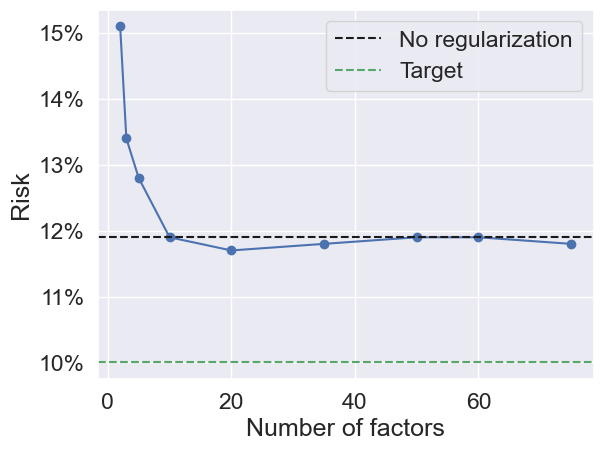

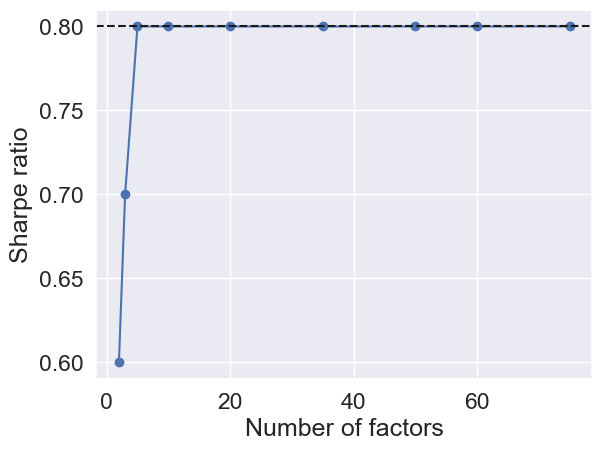

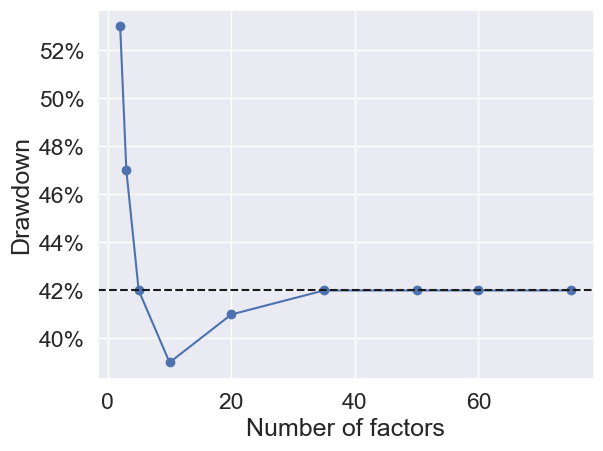

In [10]:
risks = [15.1, 13.4, 12.8, 11.9, 11.7, 11.8, 11.9, 11.9, 11.8]
risk_no_reg = 11.9
sharpe_ratios = [0.6, 0.7, 0.8,0.8,0.8,0.8,0.8,0.8,0.8]
SR_no_reg = 0.8
drawdowns = [53, 47, 42, 39, 41, 42, 42, 42, 42]
drawdown_no_reg = 42

ranks = [2, 3, 5, 10, 20, 35, 50, 60, 75]

plt.figure()
plt.plot(ranks, risks, marker="o")
plt.xlabel("Number of factors")
plt.ylabel("Risk")
plt.axhline(risk_no_reg, c="k", ls="--", label="No regularization")
plt.axhline(10, c="g", ls="--", label="Target")
# Add percentage sign to yticks
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])
plt.legend()

plt.figure()
plt.plot(ranks, sharpe_ratios, marker="o")
plt.xlabel("Number of factors")
plt.ylabel("Sharpe ratio")
plt.axhline(SR_no_reg, c="k", ls="--", label="No regularization")

plt.figure()
plt.plot(ranks, drawdowns, marker="o")
plt.xlabel("Number of factors")
plt.ylabel("Drawdown")
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x/100) for x in vals])
plt.axhline(drawdown_no_reg, c="k", ls="--", label="No regularization")


In [93]:
rets = pd.Series(traders_min_risk["No regularization"].rets.flatten(), index=traders_min_risk["No regularization"].returns.index)
rets.to_csv("results/after_comb_min_risk_noreg.csv")

In [87]:
118525.7 / 100**2

11.85257

In [85]:
1191.7 / 100**2

0.11917

In [28]:
### No reg with factor form
sigma_tar = 0.1 * 100
traders_min_risk_factor["Full"].diluted = False
traders_min_risk_factor["Full"].adjust_factor = 100
create_table(traders_min_risk_factor, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   Full & 9.2\% & 11.9\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [90]:
### No regularization
sigma_tar = 0.1 * 100
traders_min_risk["No regularization"].diluted = False
create_table(traders_min_risk, sigma_tar, rf, excess, prescient=False)

\begin{tabular}{lcccc}
   \toprule
   {Predictor} & {Return} & {Risk} & {Sharpe} & {Drawdown} \\
   \midrule
   No regularization & 9.2\% & 11.9\% & 0.8 & 42\% \\
   \hline
   \bottomrule
\end{tabular}


In [16]:
ll_r2 = pd.read_csv("results/after_comb_ll_r=2.csv",index_col=0).squeeze()
ll_r5 = pd.read_csv("results/after_comb_ll_r=5.csv",index_col=0).squeeze()
ll_r10 = pd.read_csv("results/after_comb_ll_r=10.csv",index_col=0).squeeze()
ll_r20 = pd.read_csv("results/after_comb_ll_r=20.csv",index_col=0).squeeze()
ll_r35 = pd.read_csv("results/after_comb_ll_r=35.csv",index_col=0).squeeze()
ll_r50 = pd.read_csv("results/after_comb_ll_r=50.csv",index_col=0).squeeze()
ll_r60 = pd.read_csv("results/after_comb_ll_r=60.csv",index_col=0).squeeze()
ll_r75 = pd.read_csv("results/after_comb_ll_r=75.csv",index_col=0).squeeze()
ll_no_reg = pd.read_csv("results/after_comb_ll_r=None.csv",index_col=0).squeeze()

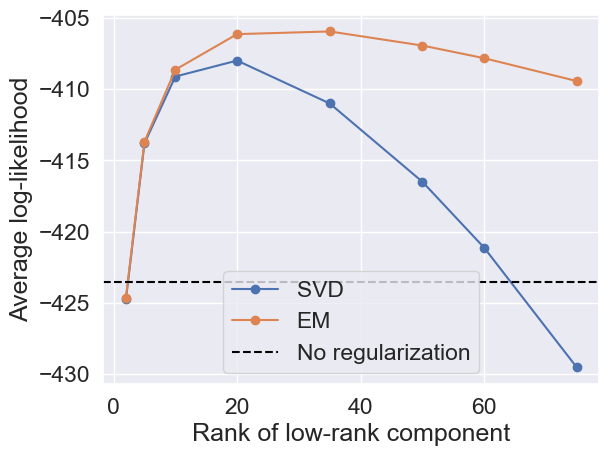

In [21]:
avg_ll_reg = [ll_r2.mean(), ll_r5.mean(), ll_r10.mean(), ll_r20.mean(), ll_r35.mean(), ll_r50.mean(), ll_r60.mean(), ll_r75.mean()]
avg_ll_reg_em = [ll2.mean(), ll5.mean(), ll10.mean(), ll20.mean(), ll35.mean(), ll50.mean(), ll60.mean(), ll75.mean()]

ranks = [2,5,10,20,35,50,60,75]

plt.plot(ranks, avg_ll_reg, marker="o", label="SVD")
plt.plot(ranks, avg_ll_reg_em, marker="o", label="EM")
plt.axhline(y=ll_no_reg.mean(), color="black", linestyle="--", label="No regularization");
plt.legend();
plt.xlabel("Rank of low-rank component");
plt.ylabel("Average log-likelihood");

In [41]:
ll_r35 = log_likelihood_regularized(returns, covariance_no_reg, r=35)


In [15]:
print(0)
ll_r2 = log_likelihood_regularized(returns, covariance_no_reg, r=2)

print(1)
ll_r60 = log_likelihood_regularized(returns, covariance_no_reg, r=60)

0
1


In [5]:
print(0)
ll_r2 = log_likelihood_regularized(returns, covariance_no_reg, r=2)

print(1)
ll_r5 = log_likelihood_regularized(returns, covariance_no_reg, r=5)

print(2)
ll_r10 = log_likelihood_regularized(returns, covariance_no_reg, r=10)

print(3)
ll_r20 = log_likelihood_regularized(returns, covariance_no_reg, r=20)

print(4)
ll_r50 = log_likelihood_regularized(returns, covariance_no_reg, r=50)

print(5)
ll_r60 = log_likelihood_regularized(returns, covariance_no_reg, r=60)

print(6)
ll_r75 = log_likelihood_regularized(returns, covariance_no_reg, r=75)


print(9)
ll_no_reg = log_likelihood_regularized(returns, covariance_no_reg, r=None)

0
1
2
3
4
5
6
7


In [42]:
all_lls = [ll_r2, ll_r5, ll_r10, ll_r20, ll_r35, ll_r50, ll_r60, ll_r75, ll_no_reg]

names = ['r=2', 'r=5', 'r=10', 'r=20', 'r=35', 'r=50', 'r=60', 'r=75', 'r=None']

log_likelihoods = {}

for i in range(len(all_lls)):
    log_likelihoods[names[i]] = all_lls[i]

In [43]:
# # Save to csv

# for i, ll in enumerate(all_lls):
#     ll.to_csv(f"results/after_comb_ll_{names[i]}.csv")

In [38]:
start_date = [*covariance_no_reg.keys()][250]
end_date = [*covariance_no_reg.keys()][-1]

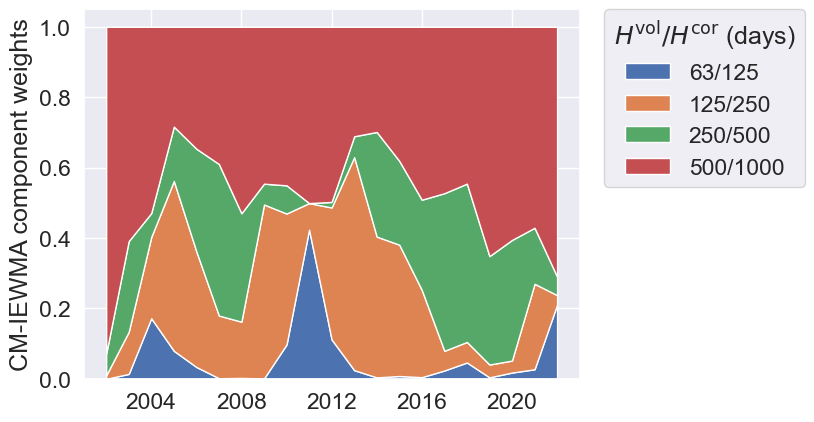

In [14]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

# Log-likelihood

Text(0, 0.5, 'Average quarterly log-likelihood')

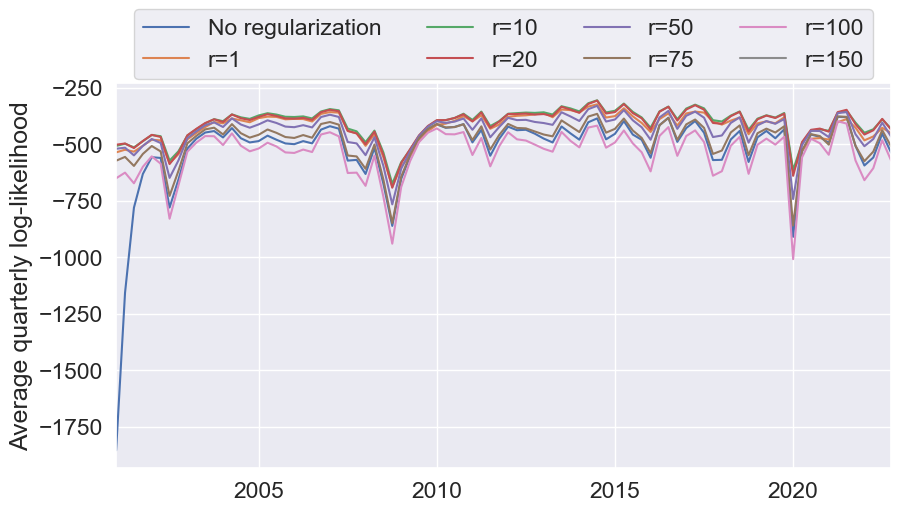

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:]:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
# plt.ylim(-700,-200);

In [44]:
# Plot average log-likelihood vs r
rs = [2, 5, 10, 20, 35, 50, 60, 75, 238]

avg_log_likelihoods = []
for name in names[:]:
    avg_log_likelihoods.append(log_likelihoods[name].mean())

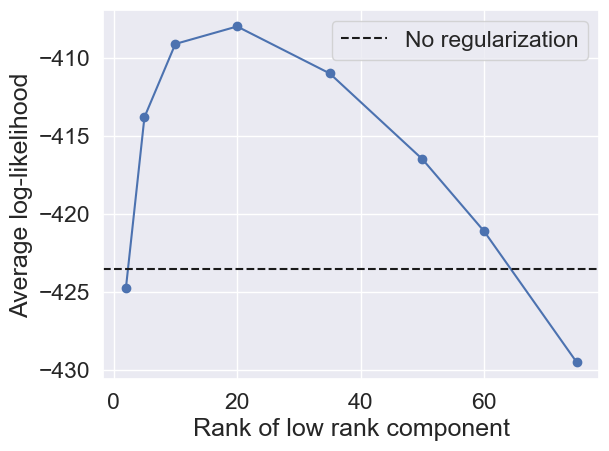

In [45]:
plt.plot(rs[:-1], avg_log_likelihoods[:-1], marker="o");
plt.xlabel("Rank of low rank component")
plt.ylabel("Average log-likelihood");
# Plot horizontal line for no regularization ll_no_reg.mean()
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.legend();

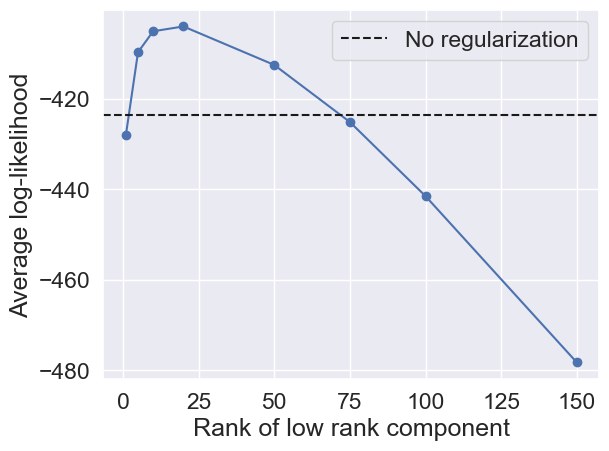

In [95]:
plt.plot(rs[:-1], avg_log_likelihoods[:-1], marker="o");
plt.xlabel("Rank of low rank component")
plt.ylabel("Average log-likelihood");
# Plot horizontal line for no regularization ll_no_reg.mean()
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.legend();

# Traditional factor model

### No regularization

In [3]:
### No mean adjustment
k = returns.shape[1]
cm_iewma_pairs = [(int(k/2), k), (k, 3*k), (3*k, 6*k)]

# CM-IEWMA
print("Computing IEWMAs")
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=250)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
print("Done computing IEWMAs")

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Computing IEWMAs
Done computing IEWMAs


100%|██████████| 5466/5466 [10:45<00:00,  8.47it/s]  


In [4]:
Sigmas = {result.time: result.covariance for result in results}

In [6]:
ll_no_reg = log_likelihood_regularized(returns, Sigmas, r=None)

In [9]:
k=20
cm_iewma_pairs = [(int(k/2), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model20 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:19<00:00,  6.36s/it]


In [10]:
ll_20 = factor_log_likelihood(returns, factor_model20)

In [11]:
k=2
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model2 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [01:53<00:00,  5.15s/it]


In [12]:
ll_2 = factor_log_likelihood(returns, factor_model2)

In [13]:
k=5
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model5 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [01:57<00:00,  5.34s/it]


In [14]:
ll_5 = factor_log_likelihood(returns, factor_model5)

In [15]:
k=10
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model10 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:05<00:00,  5.70s/it]


In [16]:
ll_10 = factor_log_likelihood(returns, factor_model10)

In [17]:
k=35
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model35 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [02:46<00:00,  7.56s/it]


In [18]:
ll_35 = factor_log_likelihood(returns, factor_model35)

In [19]:
k=50
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model50 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

100%|██████████| 22/22 [03:31<00:00,  9.62s/it]


In [20]:
ll_50 = factor_log_likelihood(returns, factor_model50)

In [21]:
k=60
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model60 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

 68%|██████▊   | 15/22 [03:12<01:44, 14.88s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.
Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


 73%|███████▎  | 16/22 [03:24<01:24, 14.12s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


100%|██████████| 22/22 [04:43<00:00, 12.89s/it]


In [22]:
ll_60 = factor_log_likelihood(returns, factor_model60)

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [23]:
k=75
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model75 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

 77%|███████▋  | 17/22 [03:35<01:15, 15.02s/it]

Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.


100%|██████████| 22/22 [04:53<00:00, 13.34s/it]


In [24]:
ll_75 = factor_log_likelihood(returns, factor_model75)

/Users/kasper/Documents/Stanford/Research/My papers/w_it_ewma/publicRepo/cov_pred_finance/.venv/lib/python3.9/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [25]:
avg_log_likelihoods = []
avg_log_likelihoods.append(ll_2.mean())
avg_log_likelihoods.append(ll_5.mean())
avg_log_likelihoods.append(ll_10.mean())
avg_log_likelihoods.append(ll_20.mean())
avg_log_likelihoods.append(ll_35.mean())
avg_log_likelihoods.append(ll_50.mean())
avg_log_likelihoods.append(ll_60.mean())
avg_log_likelihoods.append(ll_75.mean())

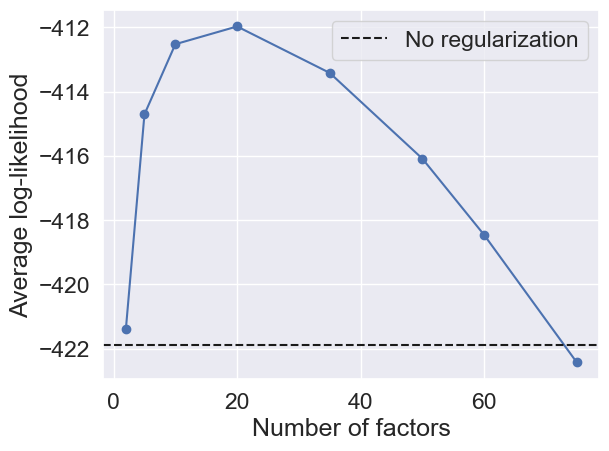

In [28]:
ks = [2, 5, 10, 20, 35, 50, 60, 75]
plt.plot(ks, avg_log_likelihoods, marker="o");
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.xlabel("Number of factors")
plt.ylabel("Average log-likelihood");
plt.legend();

In [ ]:
ll_75 = factor_log_likelihood(returns, factor_model75)

In [ ]:
k=100
cm_iewma_pairs = [(int(np.ceil(k/2)), k), (k, 3*k), (3*k, 6*k)]

memory = 500
factor_model100 = list(construct_cmiewma_factor_model(returns, k, cm_iewma_pairs, update_frequency=250, memory=memory))

In [ ]:
ll_100 = factor_log_likelihood(returns, factor_model100)

In [ ]:
rs = [1, 10, 20, 50, 75, 100, 238]


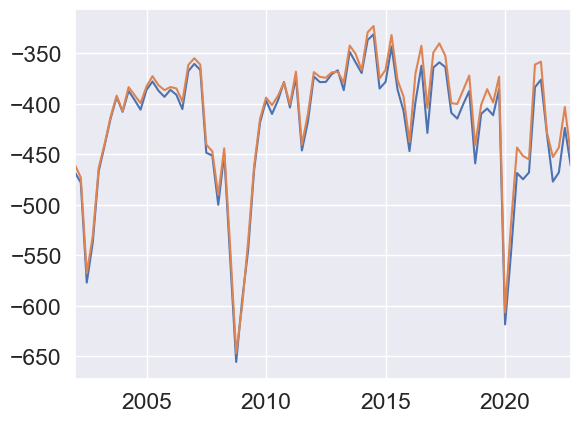

In [252]:
ll_2.resample("Q").mean().plot()
ll_20.resample("Q").mean().plot();

In [ ]:
ll_2.to_csv(f"results/factor_ll_2.csv")
ll_5.to_csv(f"results/factor_ll_5.csv")
ll_10.to_csv(f"results/factor_ll_10.csv")
ll_20.to_csv(f"results/factor_ll_20.csv")
ll_35.to_csv(f"results/factor_ll_35.csv")
ll_50.to_csv(f"results/factor_ll_50.csv")
ll_60.to_csv(f"results/factor_ll_60.csv")
ll_75.to_csv(f"results/factor_ll_75.csv")


In [29]:
ll_100

NameError: name 'll_100' is not defined